### Imports

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

#### Paths

In [38]:
RAW_DATA_PATH = '/home/jupyter/raw_data/'
DATA_PATH = '/home/jupyter/data/'

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')

# YOLOv3 training weights will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

DATA_EXTENSION_FILE_PATH = os.path.join(CONFIG_PATH, 'ih_fp.data')



#### Loss

15175
302


(200.0, 600.0)

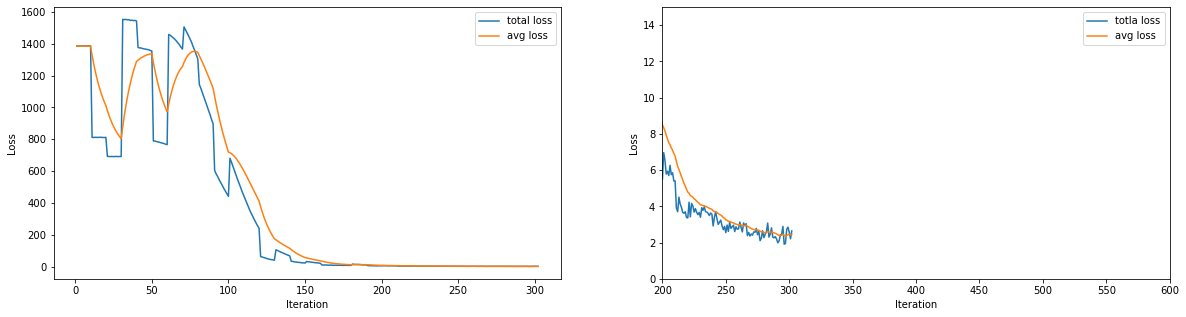

In [39]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

print(i)
print(max(iters))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 15])
plt.xlim([200,600])

#### IOU

Text(0, 0.5, 'IOU')

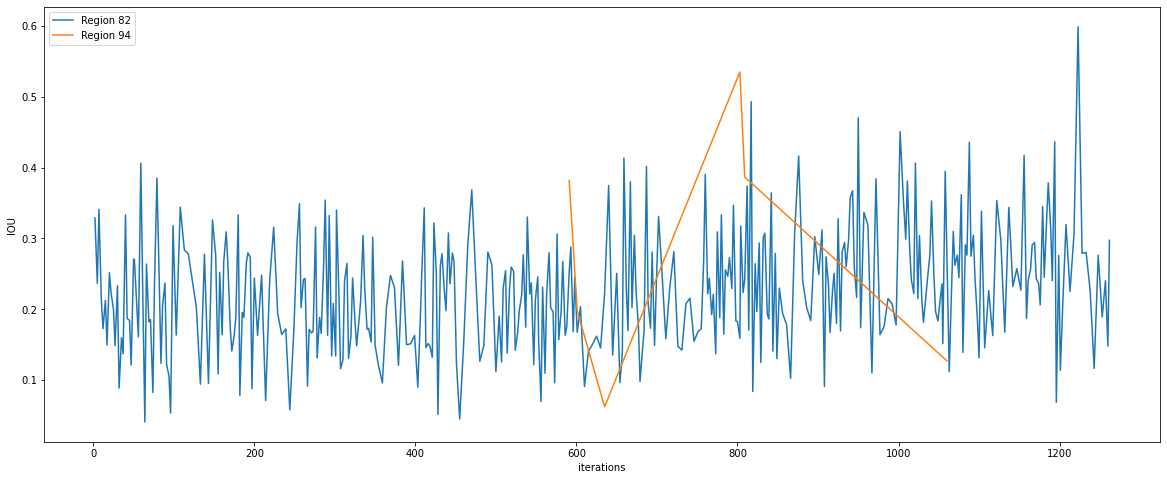

In [36]:
iters = []
IOU_value_82 = []
IOU_value_94 = []
IOU_value_106 = []

count = 0
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):

        if "Region 82" in line and count%10==0:
            
            IOU_value_82.append(float(line.strip().split(',')[0].split(' ')[4]))
            iters.append(count/10)
            
        if "Region 94" in line and count%10==0:
            
            IOU_value_94.append(float(line.strip().split(',')[0].split(' ')[4]))
     
        if "Region 106" in line and count%10==0:
            
            IOU_value_106.append(float(line.strip().split(',')[0].split(' ')[4]))
        
        count += 1
        
len_data = min(len(iters),len(IOU_value_82),len(IOU_value_94),len(IOU_value_106))
    
plt.figure(figsize=(20, 8))
sns.lineplot(iters[:len_data], IOU_value_82[:len_data], label='Region 82')
sns.lineplot(iters[:len_data], IOU_value_94[:len_data], label='Region 94')
sns.lineplot(iters[:len_data], IOU_value_106[:len_data], label='Region 106')
plt.xlabel("iterations")
plt.ylabel("IOU")

In [6]:
#!cd darknet && ./darknet detector test ../cfg/test.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_200.weights ../test.jpg -thresh 0.01

In [7]:
#!cd darknet

In [8]:
from ctypes import *

In [9]:
lib = CDLL("./darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)

In [10]:
#!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [11]:
from darknet import *

In [28]:
threshold = 0.15

In [13]:
submit_file_path = "submission.json"
cfg_path_2 = os.path.join(CONFIG_PATH, "yolov3_ih_fp.cfg_test")
weight_path = os.path.join(BACKUP_PATH, "yolov3_ih_fp_200.weights")

test_img_list_path = os.path.join(METADATA_PATH, "test_list.txt")

In [14]:
load_net = lib.load_network
load_meta = lib.get_metadata
load_image = lib.load_image_color

In [15]:
gpu_index = 0
net = load_net(cfg_path_2.encode(),
               weight_path.encode(), 
               gpu_index)
meta = load_meta(DATA_EXTENSION_FILE_PATH.encode())

In [29]:
submit_dict = {"ImageId": [], "PredictionString": []}
count = 0
with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        if count > 100:
            break
            
        count +=1
        image_id = line.strip().split('/')[-1].strip().split('.')[0]
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        submit_line = []
        for e in infer_result:

            label = e[0]
            confi = e[1]

            rw = e[2][2]
            rh = e[2][3]
            rcx = e[2][0]
            rcy = e[2][1]
           
            
            submit_line.append([confi, rcx, rcy, rw, rh])
        submit_dict["ImageId"].append(image_id)
        submit_dict["PredictionString"].append(submit_line)


pd.DataFrame(submit_dict).to_json(submit_file_path)

101it [00:13,  7.44it/s]


In [30]:
submissions = pd.read_json('submission.json')
submissions.set_index("ImageId", inplace=True)
submissions.head(20)

,PredictionString
ImageId,
85050fd12c8c9b9c,"[[0.1813565195, 400.0694580078, 297.2416381836..."
501951b9749a261c,"[[0.1813565195, 400.0694580078, 297.2416381836..."
8e286c2fde17a946,"[[0.1813565195, 400.0694580078, 297.2416381836..."
b6b6a86f24880bd0,"[[0.1813565195, 400.0694580078, 297.2416381836..."
5d15697905c24fcf,"[[0.1813565195, 400.0694580078, 297.2416381836..."
0ec9d54dcc9d087c,"[[0.1813565195, 400.0694580078, 297.2416381836..."
c520ffd5ae23f5f2,"[[0.1813565195, 400.0694580078, 297.2416381836..."
762526f6bff495cb,"[[0.1813565195, 400.0694580078, 297.2416381836..."
62ec566e3ad802da,"[[0.1813565195, 400.0694580078, 297.2416381836..."


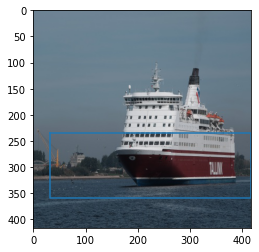

In [31]:
ex_image_id = '85050fd12c8c9b9c'
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
#ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))
df_predict = list(submissions['PredictionString'].loc[ex_image_id])

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
plt.ylim([416, 0])
plt.xlim([0,416])

for row in df_predict:
    confianza, rcx, rcy, rw, rh = [float(i) for i in row]
    x = rcx - rw/2
    y = rcy - rh/2
    w = rw
    h = rh
    
    xmin = max(0,x)
    xmax = min(x+w,416)
    ymin = max(0,y)
    ymax = min(y+h,416)
    
    #plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
    plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin])
    

In [ ]:
#!cd darknet && ./darknet detector test ../cfg/test.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_200.weights ../test.jpg -thresh 0.1

In [68]:
#!cd darknet && ./darknet detector map test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_200.weights -dont_show -ext_output < data/train.txt > result.txt

/bin/sh: 1: cannot open data/train.txt: No such file


In [62]:
#!cd darknet detector recall cfg/test.data cfg/yolov3_ih_fp.cfg_test backup/yolov3_ih_fp_200.weights -show -ext_output < metadata/test_list.txt > result.txt

In [65]:
!cd darknet && ./darknet detector test ../cfg/test.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_400.weights -thresh 0.005 result.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8                 104 x 